In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Proyecto_Inteligencia_Artificial/data' 
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Proyecto_Inteligencia_Artificial/data
/content/drive/My Drive/Proyecto_Inteligencia_Artificial/data


In [2]:
!pip install wordcloud
!pip install nltk
!pip install contractions
!pip install inflect

     |████████████████████████████████| 317kB 3.7MB/s 
     |████████████████████████████████| 245kB 8.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81700 sha256=21ece9a49cf3912a62626bb910de2a1c33622dfacdd708525cf2a30e53e46c9b
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [26]:
import pandas as pd
import numpy as np

import os
import io
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 

import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('spam.csv', engine='python')

In [5]:
df.head(25)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### Preparando el Dataset
Se eliminaron las columnas Unnamed:2,3,4 debido a la poca informacion que aportan

In [6]:
del df['Unnamed: 2'], df['Unnamed: 3'], df['Unnamed: 4']
df = df.rename(columns={"v1":"label", "v2":"text"})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Añadiendo un label para saber numericamente cual es un mensaje Ham o Spam

In [8]:
df['spam'] = df['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
df.head()

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Añadiendo una columna de la longitud de cada mensaje

In [9]:
df['length'] = df['text'].apply(len)
df.head()

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


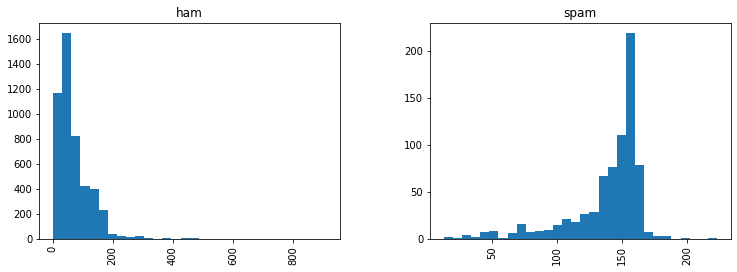

In [10]:
df.hist(column='length',by='label',bins=30,figsize=(12,4));

Se nota que los mensajes Spam contienen menos caracteres con respecto a los mensajes Ham

Separamos la data en dos arrays diferentes para su preprocesamiento individual-

In [11]:
data_ham  = df[df['spam'] == 0].copy()
data_spam = df[df['spam'] == 1].copy()

In [12]:
print(data_ham.text)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
6       Even my brother is not like to speak with me. ...
                              ...                        
5565                                         Huh y lei...
5568                Will �_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 4825, dtype: object


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
 2   spam    5572 non-null   int64 
 3   length  5572 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


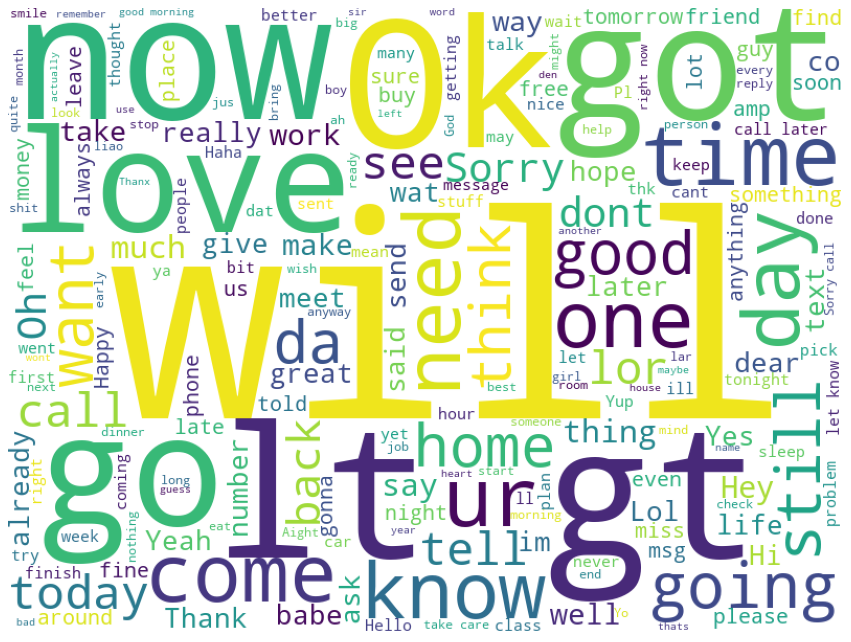

In [14]:
plt.figure(figsize=(15,15))
text = ' '.join(data_ham['text'].astype(str).tolist())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color='white', colormap='viridis', width=800, height=600).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Palabras mas usadas en los mensajes Ham, sin contar las palabras vacia (stopwords)

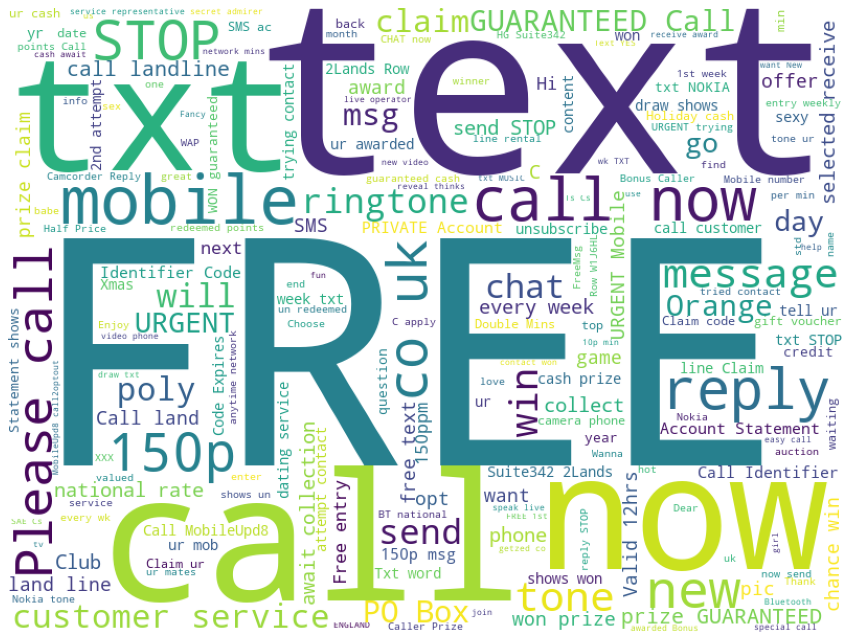

In [15]:
plt.figure(figsize=(15,15))
text = ' '.join(data_spam['text'].astype(str).tolist())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color='white', colormap='viridis', width=800, height=600).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Palabras mas usadas en los mensajes Spam, sin contar las palabras vacia (stopwords)

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
def remove_punctuation_and_stopwords(text):
    
    text_n_punt = [ch for ch in text if ch not in string.punctuation]
    text_n_punt = "".join(text_n_punt).split()
    
    text_n_punt_n_stop = [word.lower() for word in text_n_punt if word.lower() not in stopwords.words("english")]
        
    return text_n_punt_n_stop

Funcion que remueve todo signo de puntuacion y palabra vacia de la data

In [27]:
df['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [ ]:
#wordsText = df['text'].unique()
#wordsToken = np.zeros(df.shape[0] + 1, dtype=object)
#for w in range(len(wordsText)):
#    wordsToken[w] = word_tokenize(wordsText[w])
#    print(wordsToken[w], w)

#print(wordsText[8]8)
#print(df.shape[0])
#print(len(wordsText))

In [ ]:
#reviews = df.text.str.cat(sep=' ')
#tokens = word_tokenize(reviews)

In [28]:
words_data_ham = data_ham['text'].apply(remove_punctuation_and_stopwords).tolist()
words_data_spam = data_spam['text'].apply(remove_punctuation_and_stopwords).tolist()

Convertimos la data en forma de series, a una lista de palabras

In [29]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)
        
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [30]:
c_ham = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

Contamos de las listas y tomamos las palabras mas comunes en cada una

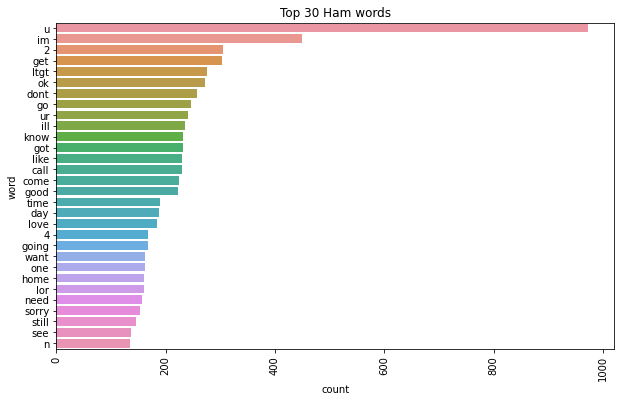

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='count', y='word', 
            data=df_hamwords_top30, ax=ax,)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

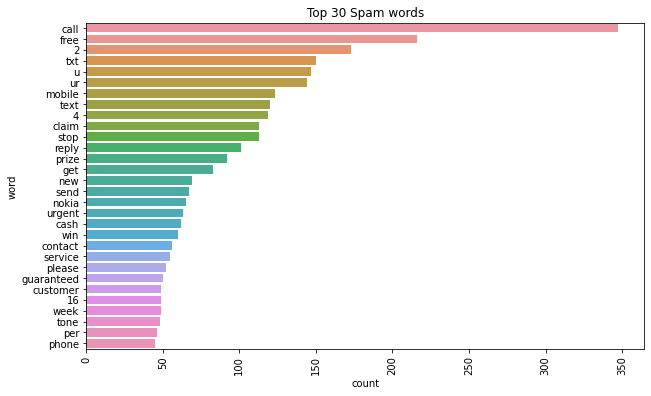

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='count', y='word', 
            data=df_spamwords_top30, ax=ax,)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## Pre-Procesamiento

Creamos una Bag of Words (BOW) o bolsa de palabras, la cual transformamos y como analizador usamos la funcion que remueve los signos de puntacion y palabras vacias

In [33]:
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(df['text'])

In [34]:
print(len(bow_transformer.vocabulary_))

9428


In [35]:
bow_data = bow_transformer.transform(df['text'])

In [36]:
bow_data.shape

(5572, 9428)

Usando el TF-IDF o Frecuencia de Término – Frecuencia Inversa de Documento, en español, revela que palabras son mas importantes para un documento.

In [37]:
tfidf_transformer = TfidfTransformer().fit(bow_data)

In [38]:
data_tfidf = tfidf_transformer.transform(bow_data)

Con la data transformada, se procede a separar la data para el entranamiento y testeo con un 80/20 respectivamente.

In [39]:
tfidf_train, tfidf_test, label_train, label_test = \
    train_test_split(data_tfidf, df["spam"], test_size=0.2)

In [40]:
tfidf_train = tfidf_train.A
tfidf_test = tfidf_test.A

#### Multinomial Naive Bayes

In [41]:
spam_detect_model = MultinomialNB().fit(tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9668161434977578


#### Gaussian Naive Bayes

In [42]:
spam_detect_model_G = GaussianNB().fit(tfidf_train, label_train)
pred_test_GNB = spam_detect_model_G.predict(tfidf_test)
acc_GNB = accuracy_score(label_test, pred_test_GNB)
print(acc_GNB)

0.8941704035874439


#### Support Vector Classifier - SVC

In [43]:
spam_detect_model_SVC = SVC().fit(tfidf_train, label_train)
pred_test_SVC = spam_detect_model_SVC.predict(tfidf_test)
acc_SVC = accuracy_score(label_test, pred_test_SVC)
print(acc_SVC)

0.9739910313901345


Su puntaje es mejor que el de GaussianNB, pero la diferencia de tiempo entre estos dos hace mejor opcion a Gaussian sobre SVC

#### Stochastic Gradient Descent - SGD

In [44]:
spam_detect_model_SGD = SGDClassifier(random_state=5).fit(tfidf_train, label_train)
pred_test_SGD = spam_detect_model_SGD.predict(tfidf_test)
acc_SGD = accuracy_score(label_test, pred_test_SVC)
print(acc_SGD)

0.9739910313901345


El puntaje es igual a de SVC, pero en tiempo de ejecucion es mejor este.

## Clasificadores con Pipeline

Con las pipelines podemos probar los clasificadores con el CounVectorizer y TF-IDF transform a la vez.

In [49]:
sms_train, sms_test, sms_label_train, sms_label_test = train_test_split(df["text"], df["spam"], test_size=0.2)

#### Pipeline SVC

In [50]:
pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                     ('tfidf'   , TfidfTransformer()), ('clf_SVC' , SVC(gamma='auto', C=1000)),])

parameters_SVC = dict(tfidf=[None, TfidfTransformer()], clf_SVC__C=[500, 1000,1500])

grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=-1, verbose=1)

In [51]:
cross_SVC = cross_val_score(pipe_SVC ,X=sms_train, y=sms_label_train , \
                            cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error), n_jobs=-1, verbose=1)

cross_pred_SVC = cross_val_predict(pipe_SVC, X=sms_train, y=sms_label_train, cv=KFold(10, shuffle=True), verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


In [52]:
print ("MSE %.3f (+/- %.5f)"%(np.mean(cross_SVC), np.std(cross_SVC)))

MSE 0.037 (+/- 0.00688)


In [53]:
print(cross_pred_SVC)
print ((np.mean(cross_pred_SVC), np.std(cross_pred_SVC)))

[0 0 0 ... 0 0 0]
(0.10365716849899036, 0.3048152881955928)


Se intento probar con un cross validation visto en el curso, pero los datos dados sobre el estimador son pobre y el tiempo de ejecucion es algo elevado para la poca data.

In [54]:
grid_SVC.fit(X=sms_train, y=sms_label_train)
pred_test_grid_SVC = grid_SVC.predict(sms_test)
acc_SVC = accuracy_score(sms_label_test, pred_test_grid_SVC)
print(acc_SVC)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


0.9820627802690582


#### Pipeline MultinomialNB

In [55]:
pipe_MNB = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),('tfidf'   , TfidfTransformer()),
                      ('clf_MNB' , MultinomialNB()),])

In [56]:
pipe_MNB.fit(X=sms_train, y=sms_label_train)
pred_test_grid_MNB = pipe_MNB.predict(sms_test)
acc_MNB = accuracy_score(sms_label_test, pred_test_grid_MNB)
print(acc_MNB)

0.9650224215246637


#### Pipeline SGD

In [57]:
pipe_SGD = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),('tfidf'   , TfidfTransformer()),
                   ('clf_SGD' , SGDClassifier(random_state=5)),])

parameters_SGD = {'tfidf__use_idf': (True, False),'clf_SGD__alpha': (1e-05, 1e-04),}

grid_SGD = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                               n_jobs=-1, verbose=1)

In [58]:
grid_SGD.fit(X=sms_train, y=label_train)
pred_test_grid_SGD = grid_SGD.predict(sms_test)
acc_SGD = accuracy_score(sms_label_test, pred_test_grid_SGD)
print(acc_SGD)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.2min finished


0.8645739910313901


## Matriz de Confusión

In [45]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="magma_r", square=True, cbar=False)
    #  
    plt.ylabel('true label')
    plt.xlabel('predicted label')

Diccionario de clasificadores

In [46]:
list_clf = ["MNB", "GNB", "SVC", "SGD"]

list_pred = [pred_test_MNB, pred_test_GNB, 
             pred_test_SVC, pred_test_SGD]

dict_pred = dict(zip(list_clf, list_pred))

In [59]:
list_grid_clf = ["MNB","SVC", "SGD"]

list_grid_pred = [pred_test_grid_MNB, pred_test_grid_SVC, pred_test_grid_SGD]

dict_grid_pred = dict(zip(list_grid_clf, list_grid_pred))

In [47]:
def plot_all_confusion_matrices(y_true, dict_all_pred, str_title):
    
    list_classifiers = list(dict_all_pred.keys())
    plt.figure(figsize=(10,9))
    plt.suptitle(str_title, fontsize=20, fontweight='bold')
    n=231

    for clf in list_classifiers : 
        plt.subplot(n)
        plot_confusion_matrix(y_true, dict_all_pred[clf])
        plt.title(clf, fontweight='bold')
        n+=1

    plt.tight_layout()
    plt.subplots_adjust()

- Correos Ham: 0
- Correso Spam: 1

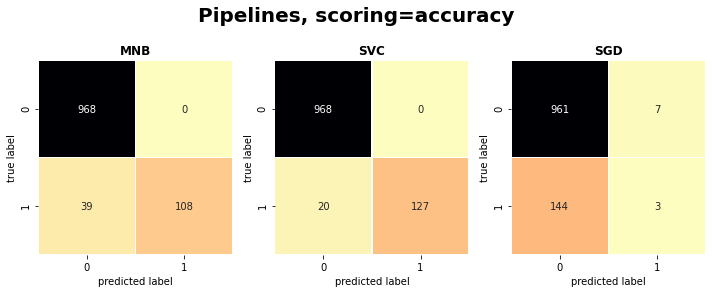

In [ ]:
plot_all_confusion_matrices(sms_label_test, dict_grid_pred, "Pipelines, scoring=accuracy")

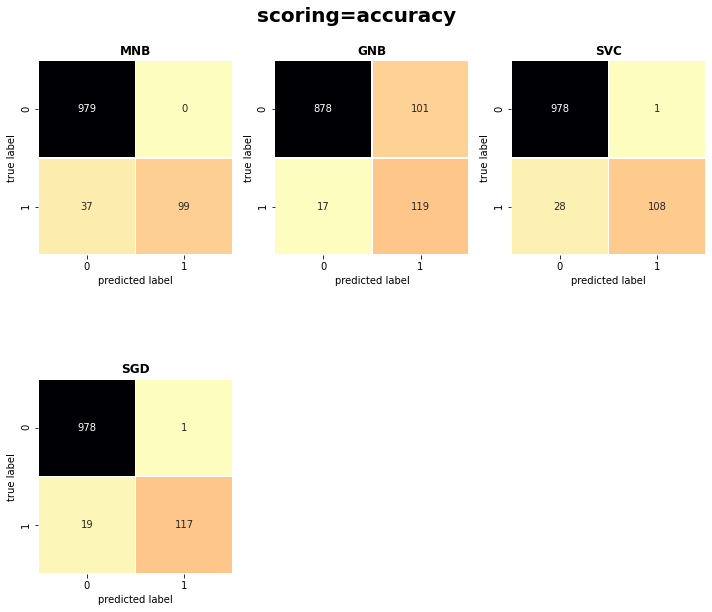

In [ ]:
plot_all_confusion_matrices(label_test, dict_pred, "scoring=accuracy")

- VN: Verdaderos negativos (correos Ham etiquetados como Ham)
- FP: Falsos positivos (correos Ham etiquetados como Spam) 
- FN: Falsos negativos (correos Spam etiquetados como Ham)
- TP: Verdaderos positivos (correos Spam etiquetados como Spam)